### Project Details:

Before you start Task 1, make sure you've read through the project description in "Project_AIPR.pdf" (used for all three tasks) found in the Files page.

### Overview of Task 1

Task 1 concerns preparing the data for later use in Tasks 2 and 3.
As part of this you will:

Handle the missing values in the data.
Preprocess the attribute values into an appropriate form to be used as input to an algorithm (as described in Project_AIPR.pdf).
Visualize the data using different techniques in order to get a sense of what it contains.
Files provided for Task 1

Task 1 uses three existing files, none of which should be part of the final submission.
Kumar2018_Article_APositionAndRotationInvariantF.pdf (A reference paper for gesture recognition)
train-final.csv
test-final.csv
All of the files can be found in the Files page.

### Handle the missing values in the data

The data in "train-final.csv" and "test-final.csv" is incomplete as there are some values that are missing. Since these are .csv (Comma-Separated Values) files this will be difficult to see in a text editor as the missing values will simply show up as two commas with nothing in between them. A better way to visualize them is to use spreadsheet software like Excel or to use RapidMiner directly. Before the data can be used these missing values needs to be replaced with filler values. How you do this is up to you, but (as detailed later) the process must be detailed in the report and the procedure for selecting replacement values must be justified. Note: If you handle the data by creating new files these new files must be part of the submission.

### Preprocess the attributes

Apply any preprocessing procedures you think would help with prediction in Tasks 2 and 3. You may use several preprocessing procedures at once and even create several different "pipelines" of procedures to see how they perform in the following tasks. Any procedures created must be reported and justified in the report.

You will be allowed to change anything you do in this task for the later tasks if need be (those tasks will have more information).

### Visualize the data

Create visualization of the data before and after preprocessing. You must at least include 2 such visualizations in the report (description and images) as well as justifications for their use and what you learned about the data from them.

### Submission

The submission consists of two parts:

The project:
The RapidMiner project (or Python code/Matlab files) that contains your solution.
Any other files used that are different from those provided to you (if you edited the provided files directly those edited versions should be included).
Anything else needed to run your project (including instructions on how to do so, if it's not self-obvious).
The report:
A report detailing how you solved the task, justification for your choices (even for choices not to do something), images of the visualizations, and what those visualizations tell you about the data and preprocessing.
Additional material

The files also include a paper "Kumar2018_Article_APositionAndRotationInvariantF.pdf" which you can consult for deeper information about gesture recognition.

The files also include "combined-1.zip" which includes the raw gesture time series as described in "Project_AIPR.pdf". You don't need to use them, but they can be used for more advanced methods for handling missing values or preprocessing.

In [1]:
%pip install pandas seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Load the train dataset
df_train = pd.read_csv("train-final.csv", header=None)

#
# Rename columns for easier reading
#

# Feature columns
df_train.rename({i:f"positions_mean_{i}" for i in range(60)}, axis=1, inplace=True)
df_train.rename({i:f"positions_std_{i}" for i in range(60,120)}, axis=1, inplace=True)
df_train.rename({i:f"angles_mean_{i}" for i in range(120,180)}, axis=1, inplace=True)
df_train.rename({i:f"angles_std_{i}" for i in range(180,240)}, axis=1, inplace=True)

# Label columns
df_train.rename({240 : "label_name", 241 : "label_code"}, axis=1, inplace=True)

train_feature_columns = df_train.columns[:-2]
n_classes = df_train.label_name.nunique()

# Show some of the data
df_train.head()

,positions_mean_0,positions_mean_1,positions_mean_2,positions_mean_3,positions_mean_4,positions_mean_5,positions_mean_6,positions_mean_7,positions_mean_8,positions_mean_9,...,angles_std_232,angles_std_233,angles_std_234,angles_std_235,angles_std_236,angles_std_237,angles_std_238,angles_std_239,label_name,label_code
0,-0.479730,0.726079,2.403713,-0.481913,0.540689,2.455865,-0.646274,0.406351,2.428461,-0.312905,...,0.730551,0.367526,0.520040,0.493564,0.485049,0.477886,0.607874,0.441320,bye,5
1,0.051888,0.646871,2.409750,0.060117,0.451912,2.449198,-0.106647,0.344324,2.461468,0.183852,...,0.428723,0.571661,0.431776,0.279627,0.595978,0.389501,0.241849,0.617291,you,30
2,-0.002692,0.624926,2.240212,0.018586,0.435987,2.269613,-0.152985,0.336314,2.305371,0.164105,...,0.537268,0.488480,0.540547,0.542650,0.430114,0.542999,0.454954,0.479623,thankyou,26
3,-0.029336,0.664426,2.443440,-0.023426,0.480809,2.451577,-0.203417,0.353489,2.506273,0.119183,...,0.713397,0.387092,0.439498,0.417769,0.554555,0.498407,0.565789,0.455313,name,20
4,0.065604,0.639172,2.377587,0.069247,0.447377,2.405972,-0.092707,0.339007,2.368022,0.231172,...,0.671461,0.475014,0.401192,0.372539,0.578720,0.446630,0.580236,0.460550,love,18


<AxesSubplot: >

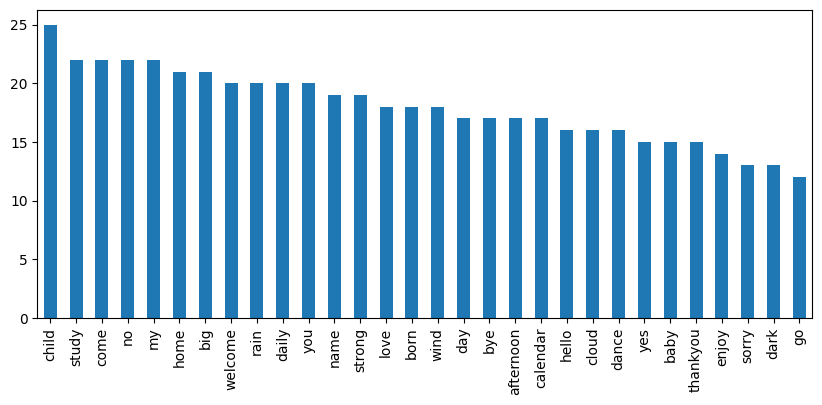

In [4]:
# Take a look at how many occurrences we have of each label
df_train.label_name.value_counts().plot(kind="bar", figsize=(10, 4))

In [5]:
# Look for columns that have missing values
columns_null_sum = df_train.isnull().sum()
columns_with_nulls = columns_null_sum[columns_null_sum > 0]

print("Total amount of missing values in the dataframe:", df_train.isnull().sum().sum())
print("Missing values in the following column indexes (and missing value count):")
print(columns_with_nulls)

# Print stats for each column
for i in columns_with_nulls.index:
    print("Column", i, "min", 
        "min", df_train[i].min(),
        "max", df_train[i].max(),
        "mean", df_train[i].mean(),
        "median", df_train[i].median(),
        "stdev", df_train[i].std())

Total amount of missing values in the dataframe: 21
Missing values in the following column indexes (and missing value count):
positions_mean_7     4
positions_mean_8     4
positions_mean_9     4
positions_mean_14    3
positions_mean_15    3
positions_mean_16    3
dtype: int64
Column positions_mean_7 min min 0.215896382 max 0.461243507 mean 0.3345816778488806 median 0.3402856735 stdev 0.05701878860959737
Column positions_mean_8 min min 1.958559157 max 2.609595816 mean 2.317619830130597 median 2.329260976 stdev 0.13021341268533476
Column positions_mean_9 min min -0.529039607 max 0.399172979 mean -0.03841945919029851 median -0.054838042000000004 stdev 0.23820936403768037
Column positions_mean_14 min min 1.826847652 max 2.619495288 mean 2.2551130643202986 median 2.252075494 stdev 0.16352055121474582
Column positions_mean_15 min min -0.441503043 max 0.551751687 mean 0.08066904289199256 median 0.081935805 stdev 0.24906213741985417
Column positions_mean_16 min min 0.013729695 max 0.627298416 

# Imputation

There are 6 columns that have missing values (3 or 4 missing values each). In order to be able to train a classifier on the data set, these missing values need to be handled. There are many different ways of handling missing values and we will explore a few of them here. To get started, let's examine the features/columns that contain missing data. The two visualizations chosen for each of the features/columns are:

- Histogram. This will give a good indication of the distribution, for example if it appears to be normal. 
- Boxplot. We get some additional information from the boxplot showing the median as well as outliers.

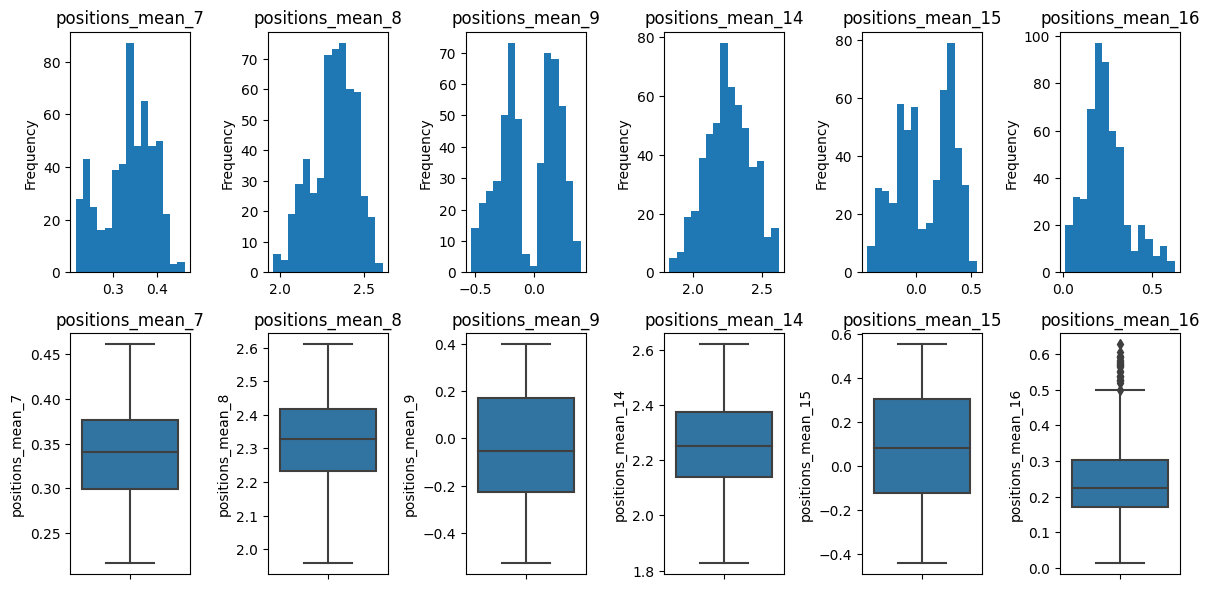

In [6]:
def plot_distributions_for_columns(df, cols):

    # Plot distributions for each of the columns that have missing values
    fig, ax = plt.subplots(2, len(cols), figsize=(12,6))

    for idx, col in enumerate(cols):
        # plot a histogram of the column for the first row
        df[col].plot(kind="hist", ax=ax[0, idx], title=col, bins=15)
        # Do a box plot as well
        sns.boxplot(y=df[col], ax=ax[1, idx]).set_title(col)
        
    plt.tight_layout()

plot_distributions_for_columns(df_train, columns_with_nulls.index)

The distributions are quite different, which mean we may need different imputation techniques for each column. For example, the columns positions_mean_9 and positions_mean_15 are clearly not normal distributions and replacing missing values with the mean, for example, would likely not be ideal. For example, for positions_mean_9 where the mean is close to 0 where few other samples are, and positions_mean_9 may even need to be split into two separate features as it appears to be the combination of two gauassian distributions.

Also, we do not know if the missing values themselves have a significance, i.e. we might want to create a separate column to indicate that a missing value is present or not. There are relatively few rows that have missing values, though, that may limit the usefulness of this technique and usefulness will also depend on the classifier used in the end.

For now, we will implement support for the following imputation strategies:

- Replacing with mean
- Drop the rows containing at least one missing value
- K-Nearest Neighbour imputation, i.e. use the mean value of K nearest neighbours

In [7]:
from sklearn.impute import KNNImputer, SimpleImputer

# KNN imputation
def impute_knn(df):
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    df = df.copy()
    df[df.columns] = imputer.fit_transform(df.values)
    return df

# Drop rows
def impute_drop_rows(df):
    return df.dropna()

# Mean imputation
def impute_mean(df):
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    df = df.copy()
    df[df.columns] = imputer.fit_transform(df.values)
    return df


Imputed values (mean)
[ 0.33458168  2.31761983 -0.03841946  0.33458168  2.31761983 -0.03841946
  0.33458168  2.31761983 -0.03841946  0.33458168  2.31761983 -0.03841946
  2.25511306  0.08066904  0.24483198  2.25511306  0.08066904  0.24483198
  2.25511306  0.08066904  0.24483198]
Imputed values (KNN)
[ 0.34047311  2.31943747  0.28644774  0.3482031   2.39881444 -0.1273677
  0.35056898  2.50631498  0.39795417  0.36853525  2.44980983 -0.2093955
  2.30348019  0.1777522   0.21750797  2.05630751  0.31015251  0.20072834
  2.31141073  0.18122421  0.22825797]
Differences
[-0.00589143 -0.00181764 -0.3248672  -0.01362142 -0.08119461  0.08894825
 -0.0159873  -0.18869515 -0.43637363 -0.03395357 -0.13219     0.17097604
 -0.04836713 -0.09708315  0.02732401  0.19880555 -0.22948347  0.04410364
 -0.05629767 -0.10055517  0.01657401]


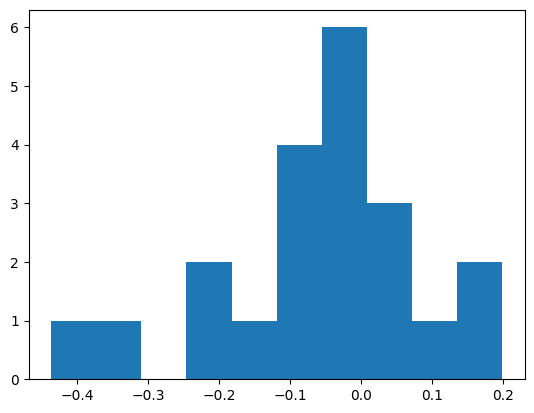

In [8]:
#
# Let's compare mean and KNN imputation
#
all_na_values = df_train[train_feature_columns].isna()

# Let's start with mean imputations and display the results
df_train_mean_impute = impute_mean(df_train[train_feature_columns])

print("Imputed values (mean)")
print(df_train_mean_impute.values[all_na_values])

df_train_knn_impute = impute_knn(df_train[train_feature_columns])
df_train_knn_impute.values[all_na_values]

print("Imputed values (KNN)")
print(df_train_knn_impute.values[all_na_values])

# Compare them
print("Differences")
diff = df_train_mean_impute.values[all_na_values] - df_train_knn_impute.values[all_na_values]
print(diff)

plt.hist(diff);

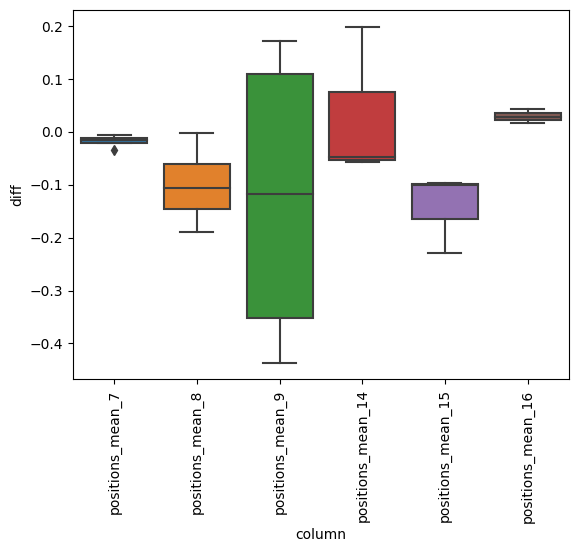

In [9]:
# Let's look at how the difference is distributed for each column
na_rows, na_cols = np.where(all_na_values)
df_diffs_columns = pd.DataFrame({"diff" : diff, "column" : df_train.columns[na_cols]})

ax = sns.boxplot( x="column", data=df_diffs_columns, y='diff')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

When comparing the imputed values between the 'mean' and 'KNN' approaches, we see that they produce very similar values for columns "positions_mean_7" and "positions_mean_16" and then larger differencies by varying degrees. The largest (absolute) deviance is for positions_mean_9.

Based in this it is likely that we may need to employ different imputation techniques depending on the column/feature.

In [10]:
# Let's use the KNN imputation
df_train[columns_with_nulls.index] = impute_knn(df_train[columns_with_nulls.index])

assert df_train.isnull().sum().sum() == 0

# Preprocssing

Some classifiers are more sensitive to the range, mean & outliers of the features, such as linear regression models, for example. In order to be able to train a wide range of classifiers and compare the,, we will need to preprocess the data for scaling and outlier treatment. Firrst we will take a look at how the data looks by feature/column. While the dataset contains a lot of features, we can use a boxplot to get an overview understanding of how the different columns compare. 

([<matplotlib.axis.XTick at 0x7fac82008d00>], [Text(1, 0, '')])

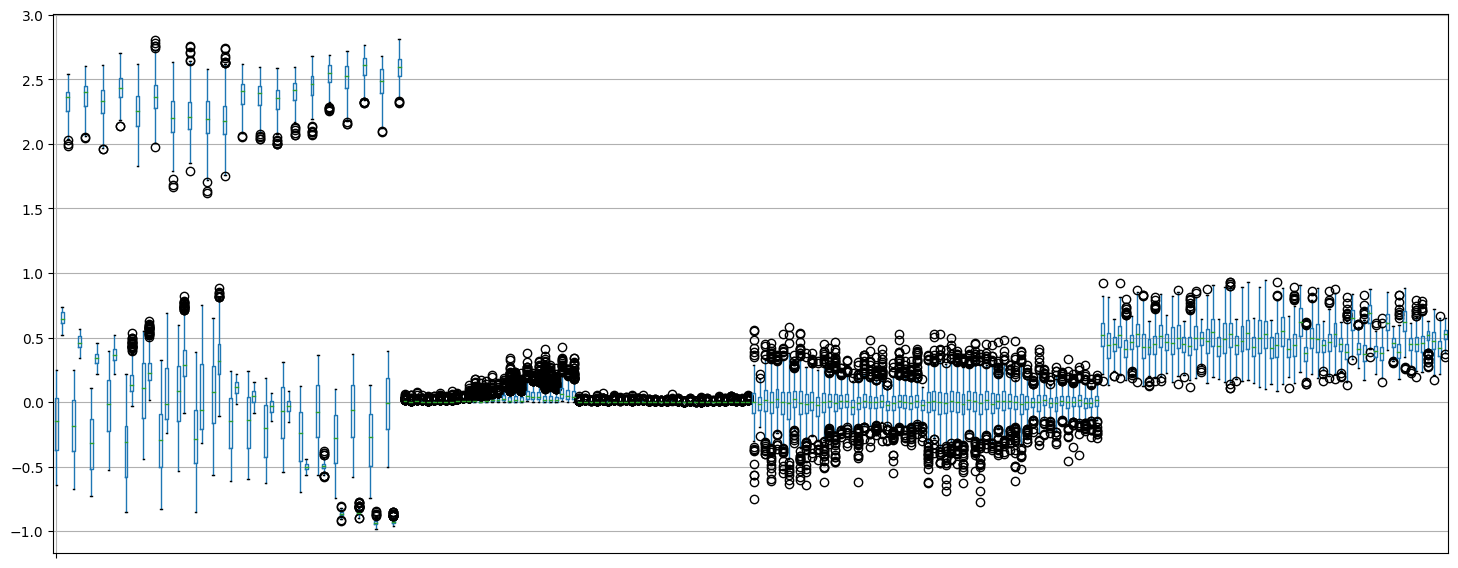

In [11]:
# Do a boxplot for every feature to get an overview of how they all relate in terms of range & center
df_train[train_feature_columns].boxplot(figsize=(18,7))
plt.xticks([1], ['']) # No need to to have labels for the feature names, we just want to show all of them in one plot

The column are clearly not all scaled to the same range and they have different means. There also appears to be quite a few outliers. As such a scaler that centers the mean and normalizes (scale to the variance) may be suitable. Let's use scikit's standard scaler for this.

In [12]:
# Preprocessing will use the standard scaler in Scikit learn which will normalize the data set (center and scale to the variance)
def preprocess(df):

    scaler = preprocessing.StandardScaler()
    scaled_values = scaler.fit_transform(df.values)
    return pd.DataFrame(scaled_values)

df_train[train_feature_columns] = preprocess(df_train[train_feature_columns])
df_train.head()

,positions_mean_0,positions_mean_1,positions_mean_2,positions_mean_3,positions_mean_4,positions_mean_5,positions_mean_6,positions_mean_7,positions_mean_8,positions_mean_9,...,angles_std_232,angles_std_233,angles_std_234,angles_std_235,angles_std_236,angles_std_237,angles_std_238,angles_std_239,label_name,label_code
0,-1.323633,1.421746,0.733025,-1.232600,1.399904,0.822277,-1.422333,1.262037,0.852106,-1.156943,...,1.047194,-1.135466,0.769486,0.395003,-0.513685,0.020178,2.181665,-1.544711,bye,5
1,1.003039,0.078953,0.794440,1.093898,-0.102009,0.757567,0.931582,0.170309,1.106539,0.927581,...,-1.823802,1.842487,-0.235120,-1.990480,1.426960,-0.876203,-2.053768,1.825020,you,30
2,0.764166,-0.293088,-0.930321,0.915639,-0.371414,-0.985672,0.729450,0.029320,-0.096725,0.844718,...,-0.791318,0.629031,1.002887,0.942327,-1.474741,0.680542,0.412169,-0.811236,thankyou,26
3,0.647555,0.376563,1.137173,0.735317,0.386874,0.780659,0.509463,0.331612,1.451922,0.656212,...,0.884029,-0.850038,-0.147232,-0.450141,0.702284,0.228297,1.694685,-1.276755,name,20
4,1.063069,-0.051572,0.467238,1.133087,-0.178730,0.337967,0.992393,0.076732,0.386219,1.126148,...,0.485131,0.432586,-0.583229,-0.954479,1.125046,-0.296817,1.861857,-1.176475,love,18


All the columns have now been scaled. Let's rerun the boxplot.

([<matplotlib.axis.XTick at 0x7fac82055700>], [Text(1, 0, '')])

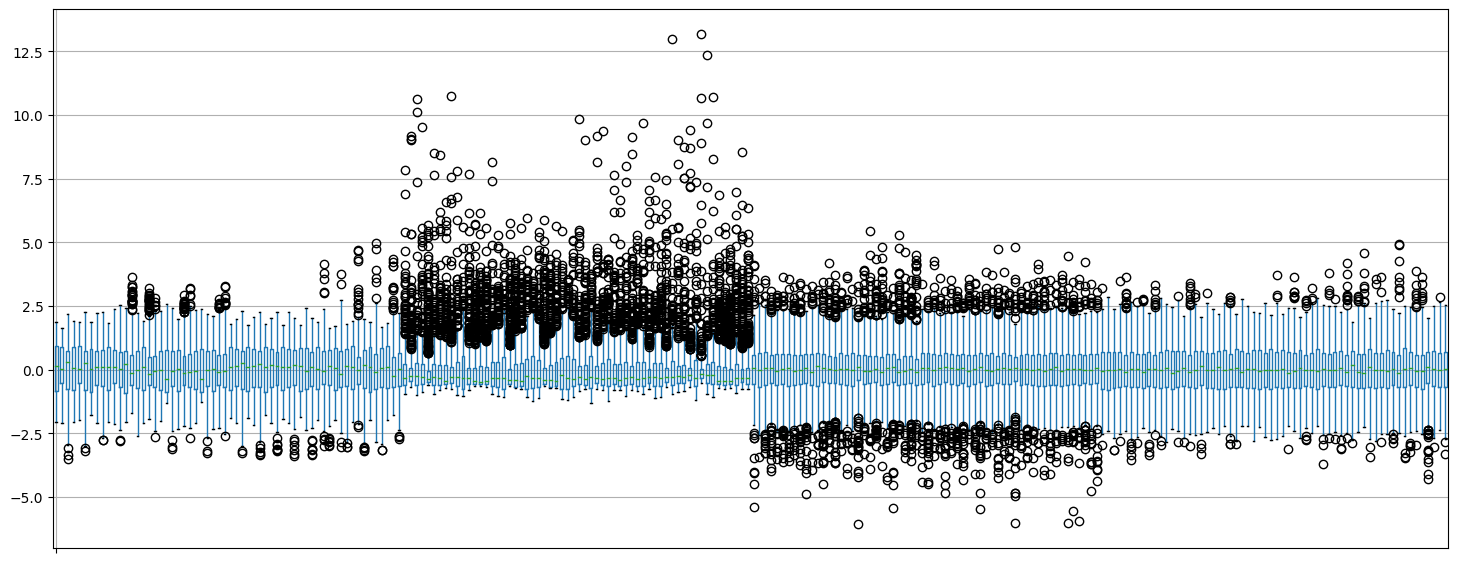

In [13]:
df_train[train_feature_columns].boxplot(figsize=(18,7))
plt.xticks([1], [''])

All columns now have their mean centered at 0 and scaled appropriately. Outliers exist in most of the features, although some have larger amount of outliers than others. Let's look at a few ways we can handle the outliers:

- tbd